In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyeit.mesh as mesh
import seaborn as sns
import tensorflow as tf
from PIL import Image
from pyeit.mesh.shape import thorax
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, perm_deviation, plot_reconstruction, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2023-11-09 12:57:49.769406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 12:57:49.769500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 12:57:49.770337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 12:57:49.861606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id="start"></a>
# Predict Lung Wings Size inside the Thorax

- [Data Overview](#data_overview)
- [**VAE**](#vae)
- [Prepare Data for Mapper Training](#prepdataformapper)
- [**Mapper Engineering**](#trainmapper)
    - [1D Mapper](#1d_mapper)
    - [2D Mapper](#2d_mapper)
    - [LSTM Mapper](#lstmmapper)
- [**Comparison**](#comparison)

<a id="data_overview"></a>
## Data Overview

The thorax data consists of multiple very raw breathing-lung-cycles periods. Therefore two circles, representing the lung wings, inside a thorax-like mesh are changed in their radius.

![gif](../images/breathing.gif)

In [2]:
l_path = "../data_thorax/h0=0.05_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=Truendiv=2/"

In [3]:
# load single simulation sample
tmp = np.load(l_path + "sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

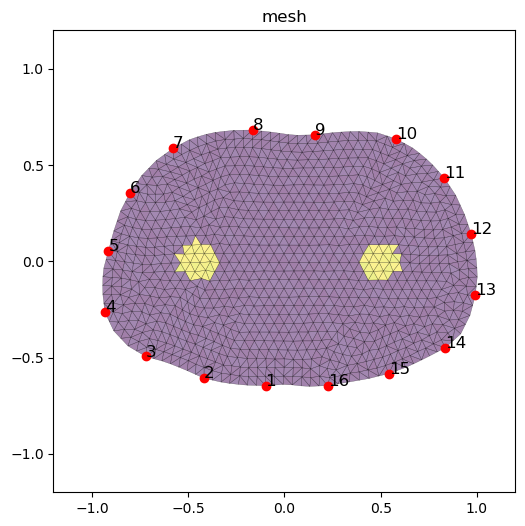

In [4]:
# create empty mesh:
# mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"], fd=thorax)
# np.save("../data_thorax/mesh_obj.npy", mesh_obj)

# load PyEITMesh
mesh_obj = np.load("../data_thorax/mesh_obj.npy", allow_pickle=True).tolist()
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [5]:
V = np.load("../data_thorax/V.npy", allow_pickle=True)
perms = np.load("../data_thorax/perms.npy", allow_pickle=True)
radii = np.load("../data_thorax/radii.npy", allow_pickle=True)

tt_spl = 8_000
V_train = V[:tt_spl]
V_test = V[tt_spl:]
perms_train = perms[:tt_spl]
np.random.shuffle(perms_train)
perms_test = perms[tt_spl:]
radii_train = radii[:tt_spl]
radii_test = radii[tt_spl:]

In [6]:
perms_train = perms[:tt_spl]

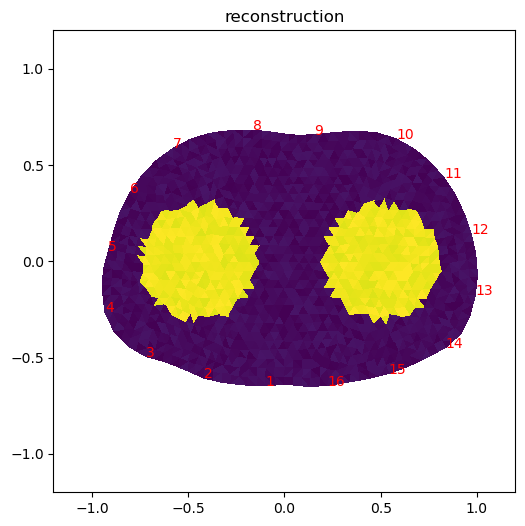

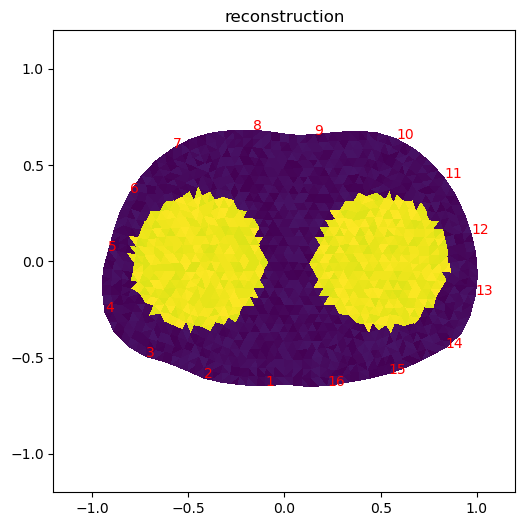

In [7]:
plot_reconstruction(mesh_obj, perms_train[0])
plot_reconstruction(mesh_obj, perms_train[1])

<a id="vae"></a>
## VAE

In [8]:
latent_dim = 8
from VAE_thorax import vae

2023-11-09 12:57:59.564558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46702 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-09 12:57:59.566594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46702 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1912)]               0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1912, 1)              0         ['input_1[0][0]']             
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 2400, 1)              0         ['reshape[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d (Conv1D)             (None, 2400, 16)             160       ['zero_padding1d[0][

In [9]:
load_vae = True

if load_vae:
    vae.build(input_shape=())
    vae.load_weights("../data_thorax/vae_w.h5")
else:
    vae.compile(Adam(), loss=tf.losses.mean_squared_error)
    history = vae.fit(perms_train, epochs=20, batch_size=32)

In [10]:
if not load_vae:
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [11]:
V = np.load("../data_thorax/V.npy", allow_pickle=True)
perms = np.load("../data_thorax/perms.npy", allow_pickle=True)
radii = np.load("../data_thorax/radii.npy", allow_pickle=True)

2023-11-09 12:58:01.959103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


1/1 [==============================] - 0s 24ms/step


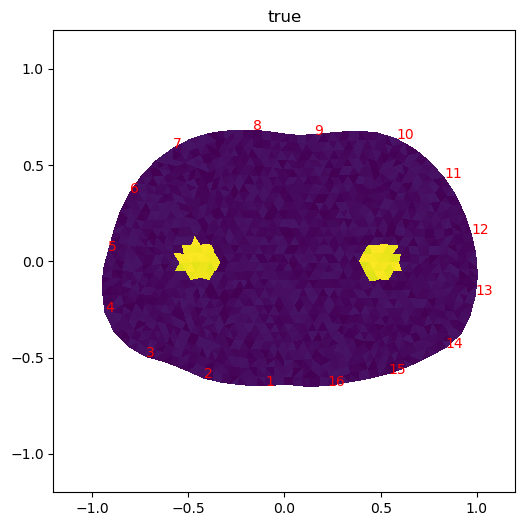

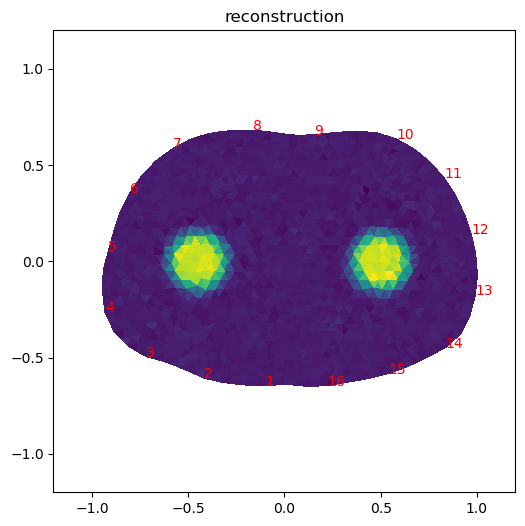

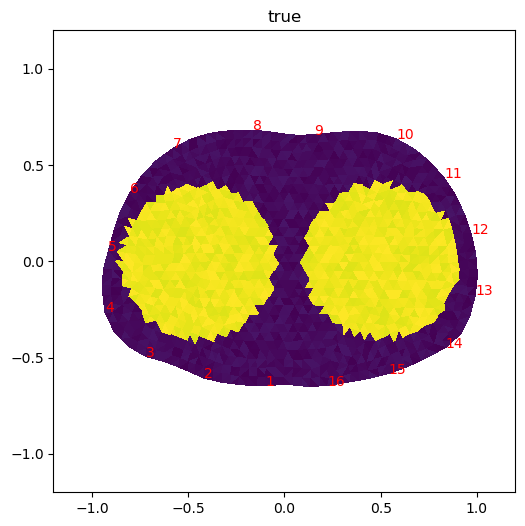

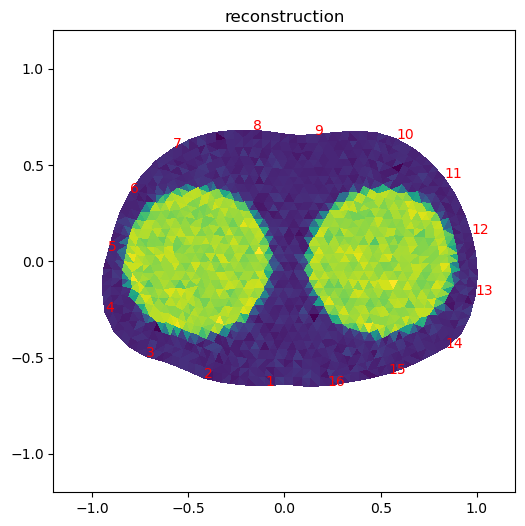

In [12]:
# reset order to default
perms_train = perms[:tt_spl]
_, _, z0 = vae.encoder.predict(np.expand_dims(perms_train[0, :], 0))
_, _, z50 = vae.encoder.predict(np.expand_dims(perms_train[50, :], 0))

plot_reconstruction(mesh_obj, perms_train[0, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z0)))
plot_reconstruction(mesh_obj, perms_train[50, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z50)))

In [13]:
train_z_mean, train_z_log_var, train_z = vae.encoder.predict(perms_train)
test_z_mean, test_z_log_var, test_z = vae.encoder.predict(perms_test)
all_z_mean, all_z_log_var, all_z = vae.encoder.predict(perms)

313/313 [==============================] - 1s 3ms/step


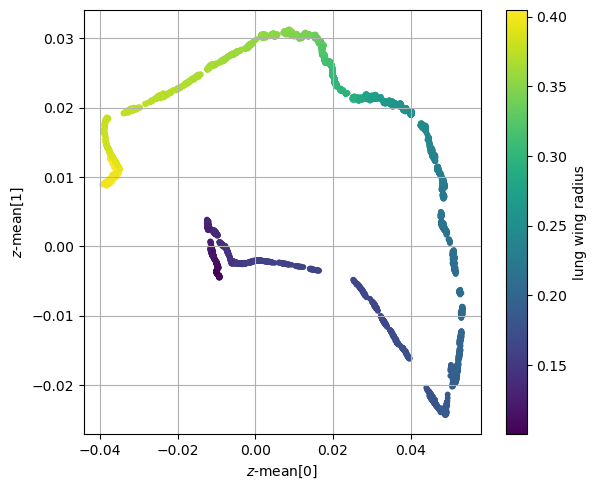

In [14]:
plt.figure(figsize=(6, 5))
plt.scatter(train_z_mean[:, 0], train_z_mean[:, 1], c=radii_train, s=10)
plt.xlabel("$z$-mean[0]")
plt.ylabel("$z$-mean[1]")
# plt.axis('off')
plt.tight_layout()
plt.grid()
# plt.savefig("../../beauty_of_latent_spaces/1.pdf")
plt.colorbar(label="lung wing radius")
plt.show()

In [15]:
show_tsne = False

if show_tsne:
    # Perform t-SNE to reduce the dimensionality to 2D
    tsne = TSNE(n_components=2)
    # latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data
    latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data

    plt.figure(figsize=(6, 5))
    plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=radii_train, s=10)
    plt.xlabel("tsne latent dimention 1")
    plt.ylabel("tsne latent dimention 2")
    plt.colorbar(label="lung wing radius")
    plt.grid()
    plt.tight_layout()
    # plt.savefig("../../beauty_of_latent_spaces/5.pdf")
    plt.show()

<a id="prepdataformapper"></a>
## Prepare Data for Mapper

In [16]:
V = np.load("../data_thorax/V.npy", allow_pickle=True)
perms = np.load("../data_thorax/perms.npy", allow_pickle=True)
radii = np.load("../data_thorax/radii.npy", allow_pickle=True)

V_train = V[:tt_spl]
V_test = V[tt_spl:]
perms_train = perms[:tt_spl]
perms_test = perms[tt_spl:]
radii_train = radii[:tt_spl]
radii_test = radii[tt_spl:]

In [17]:
nseg = 4

# train data
X_train = [V_train[n : n + nseg, :] for n in range(V_train.shape[0] - nseg + 1)]
X_train = np.array(X_train)

Y_train_v = V_train[nseg - 1 :]
Y_train_perms = perms_train[nseg - 1 :]
_, _, Y_train = vae.encoder.predict(Y_train_perms)


# test data
X_test = [V_test[n : n + nseg, :] for n in range(V_test.shape[0] - nseg + 1)]
X_test = np.array(X_test)

Y_test_v = V_test[nseg - 1 :]
Y_test_perms = perms_test[nseg - 1 :]
_, _, Y_test = vae.encoder.predict(Y_test_perms)

63/63 [==============================] - 0s 5ms/step


In [18]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print(np.allclose(X_train[0, nseg - 1, :], Y_train_v[0, :]))
print(np.allclose(X_test[0, nseg - 1, :], Y_test_v[0, :]))

(7997, 4, 192) (7997, 8)
(1997, 4, 192) (1997, 8)
True
True


<a id="trainmapper"></a>
# Mapper Engineering

- [1D Mapper](#1d_mapper)
- [2D Mapper](#2d_mapper)
- [LSTM Mapper](#lstmmapper)
- [**Comparison**](#comparison)

In [19]:
load_mapper_models = True

batch_size_m = 64
epochs_m = 25
lossf_m = tf.losses.mean_squared_error

<a id="1d_mapper"></a>
## 1D Mapper

In [20]:
def mapper_1d(input_shape=(192,), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation="relu")(mapper_inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(mapper_inputs, x)


mapper_1d = mapper_1d()
mapper_1d.compile(Adam(), loss=lossf_m)
mapper_1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192)]             0         
                                                                 
 dense_9 (Dense)             (None, 128)               24704     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
Total params: 35704 (139.47 KB)
Trainable params: 35704 (139.

In [21]:
if load_mapper_models:
    mapper_1d.load_weights("../data_thorax/mapper_1d_w.h5")
else:
    history_mapper_1d = mapper_1d.fit(
        X_train[:, 0, :],
        Y_train,
        epochs=epochs_m,
        batch_size=batch_size_m,
    )
    plt.plot(history_mapper_1d.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [22]:
# mapper_1d.save_weights("../data_thorax/mapper_1d_w.h5")

In [23]:
Perm_pred_1d = vae.decoder.predict(mapper_1d.predict(X_test[:, 0, :]))

63/63 [==============================] - 0s 4ms/step


In [24]:
err_1d = list()
for i in tqdm(range(Perm_pred_1d.shape[0])):
    err_1d.append(perm_deviation(perms_test[i, :], Perm_pred_1d[i, :]))

err_1d = np.array(err_1d)
err_1d = list((err_1d / len(tmp["perm_array"]) * 100))

100%|██████████| 1997/1997 [00:00<00:00, 31707.79it/s]


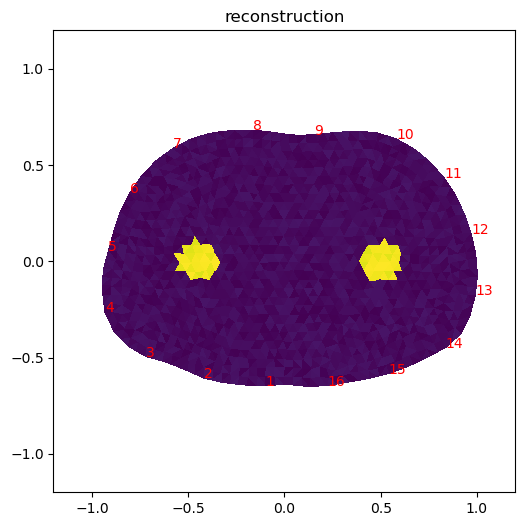

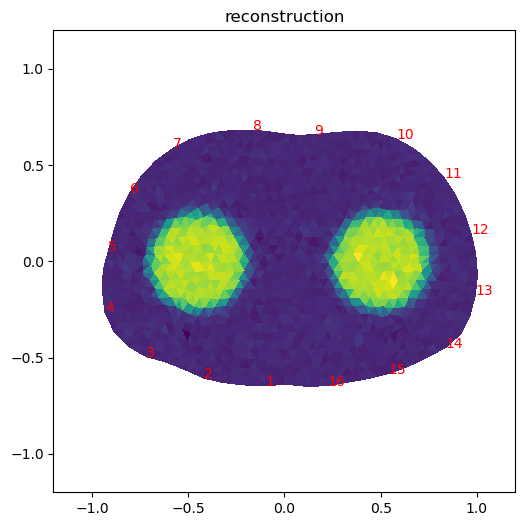

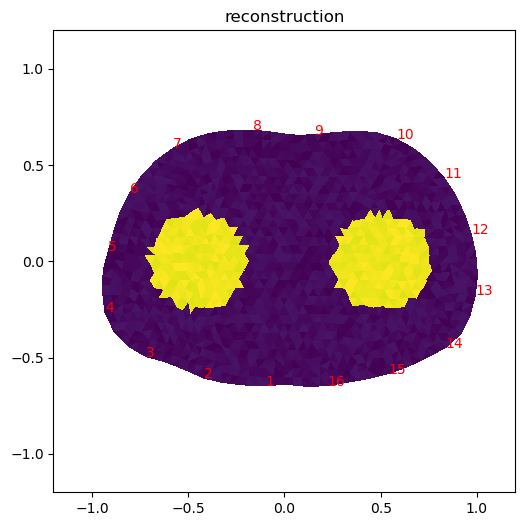

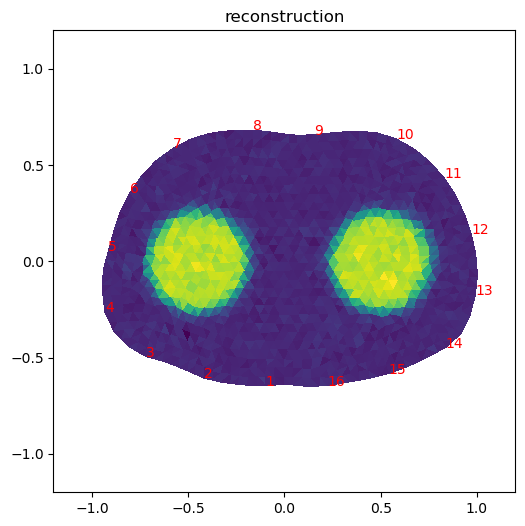

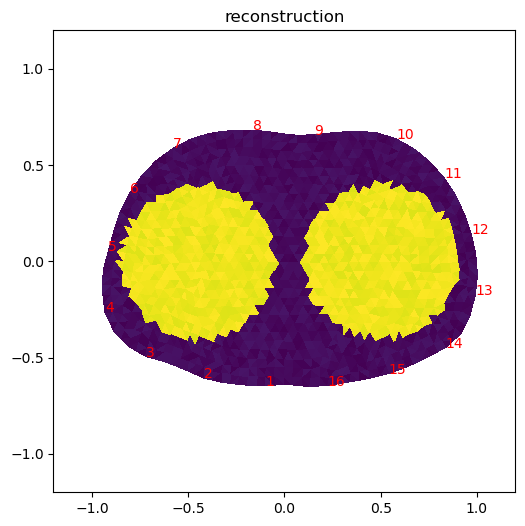

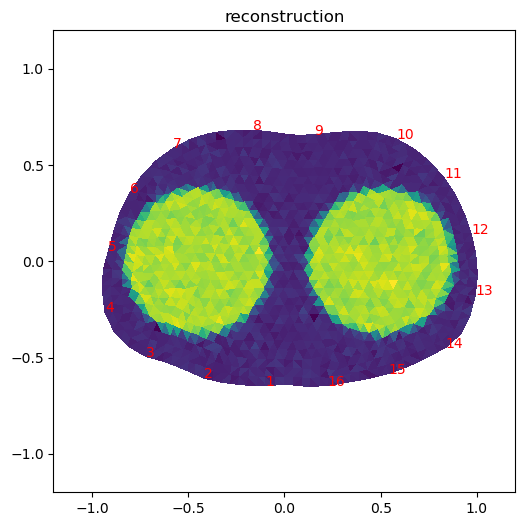

In [25]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_1d[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_1d[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_1d[50, :])

<a id="2d_mapper"></a>
## 2D Mapper

In [26]:
def mapper_2d(input_shape=(4, 192, 1), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D((0, 32))(mapper_inputs)

    x = layers.Conv2D(8, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Conv2D(16, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Flatten()(x)
    # x = layers.Dropout(0.5)(x)

    # x = layers.Reshape((4, 256))(x)
    # x = layers.LSTM(256)(x)

    x = layers.Dense(latent_dim)(x)
    return Model(mapper_inputs, x)


mapper_2d = mapper_2d()
mapper_2d.compile(Adam(), loss=lossf_m)
mapper_2d.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 192, 1)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 4, 256, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 8)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 64, 16)         528       
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 8)                 8200      
                                                           

In [27]:
if load_mapper_models:
    mapper_2d.load_weights("../data_thorax/mapper_2d_w.h5")
else:
    history_mapper_2d = mapper_2d.fit(
        X_train,
        Y_train,
        epochs=epochs_m,
        batch_size=batch_size_m,
        # validation_data=(X_test,Y_test)
    )
    plt.plot(history_mapper_2d.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [28]:
# mapper_2d.save_weights("../data_thorax/mapper_2d_w.h5")

In [29]:
Perm_pred_mapper_2d = vae.decoder.predict(mapper_2d.predict(X_test))

63/63 [==============================] - 0s 2ms/step


In [30]:
err_mapper_2d = list()
for i in tqdm(range(Perm_pred_mapper_2d.shape[0])):
    err_mapper_2d.append(perm_deviation(perms_test[i, :], Perm_pred_mapper_2d[i, :]))

err_mapper_2d = np.array(err_mapper_2d)
err_mapper_2d = list((err_mapper_2d / len(tmp["perm_array"]) * 100))

100%|██████████| 1997/1997 [00:00<00:00, 53240.94it/s]


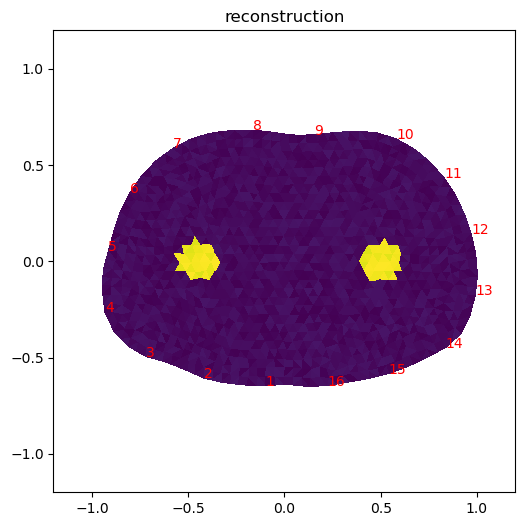

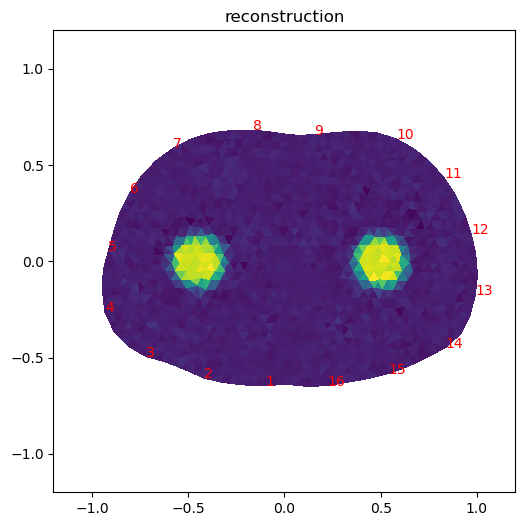

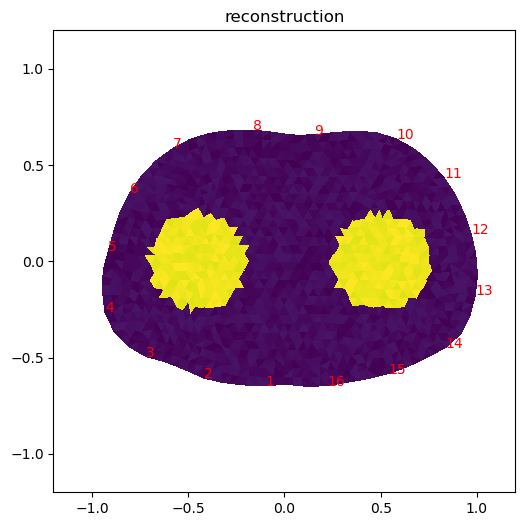

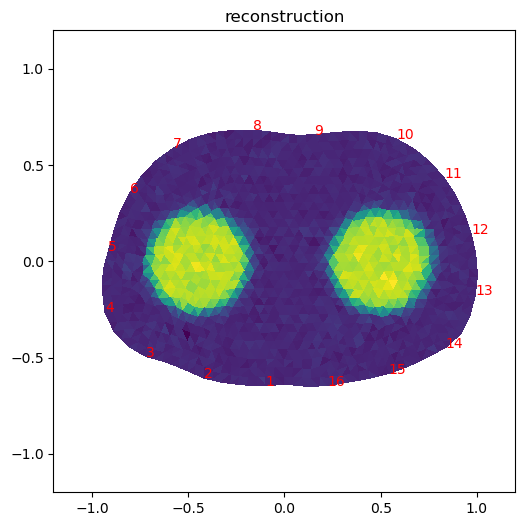

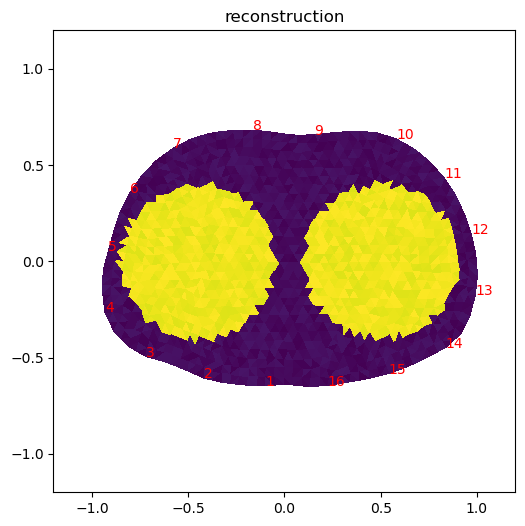

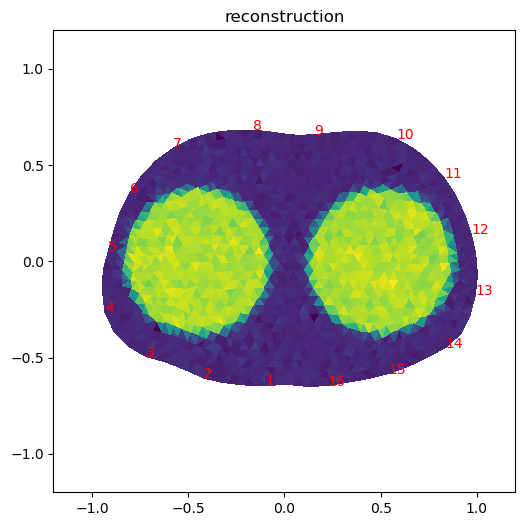

In [31]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_mapper_2d[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_mapper_2d[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_mapper_2d[50, :])

<a id="lstmmapper"></a>
## LSTM Mapper

In [32]:
def mapper_lstm(input_shape=(4, 192, 1), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D((0, 32))(mapper_inputs)

    x = layers.Conv2D(8, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Conv2D(16, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Flatten()(x)
    # x = layers.Dropout(0.5)(x)

    x = layers.Reshape((4, 256))(x)
    x = layers.LSTM(256)(x)

    x = layers.Dense(latent_dim)(x)
    return Model(mapper_inputs, x)


mapper_lstm = mapper_lstm()
mapper_lstm.compile(Adam(), loss=lossf_m)
mapper_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 192, 1)]       0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 4, 256, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 8)         40        
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 64, 16)         528       
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 256)            0         
                                                           

In [33]:
if load_mapper_models:
    mapper_lstm.load_weights("../data_thorax/mapper_lstm_w.h5")
else:
    history_mapper_lstm = mapper_lstm.fit(
        X_train,
        Y_train,
        epochs=epochs_m,
        batch_size=batch_size_m,
        # validation_data=(X_test,Y_test)
    )
    plt.plot(history_mapper_lstm.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [34]:
# mapper_lstm.save_weights("../data_thorax/mapper_lstm_w.h5")

In [35]:
Perm_pred_mapper_lstm = vae.decoder.predict(mapper_lstm.predict(X_test))

63/63 [==============================] - 0s 3ms/step


In [36]:
err_mapper_lstm = list()
for i in tqdm(range(Perm_pred_mapper_lstm.shape[0])):
    err_mapper_lstm.append(
        perm_deviation(perms_test[i, :], Perm_pred_mapper_lstm[i, :])
    )

err_mapper_lstm = np.array(err_mapper_lstm)
err_mapper_lstm = list((err_mapper_lstm / len(tmp["perm_array"]) * 100))

100%|██████████| 1997/1997 [00:00<00:00, 53151.75it/s]


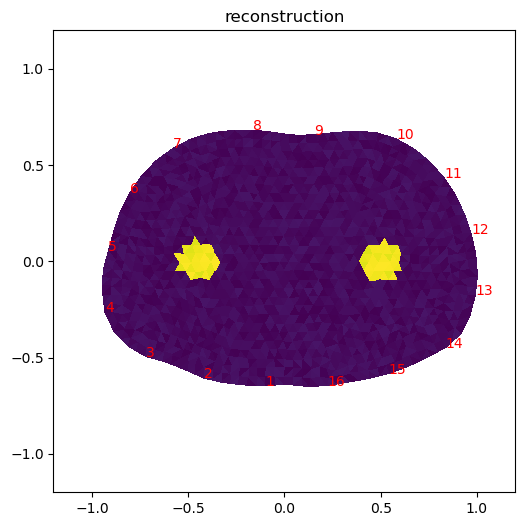

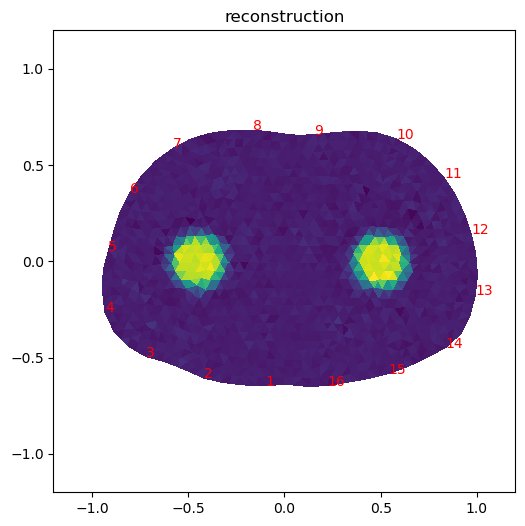

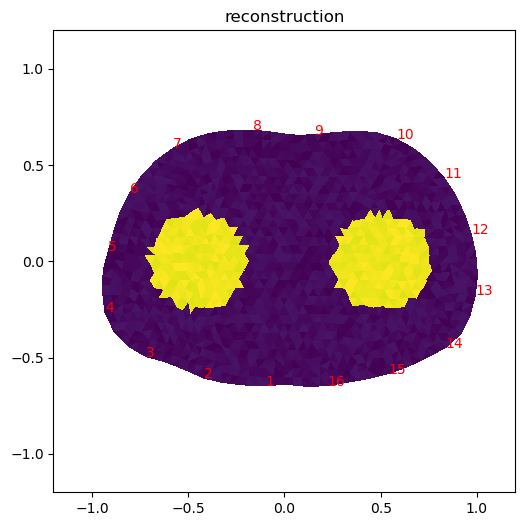

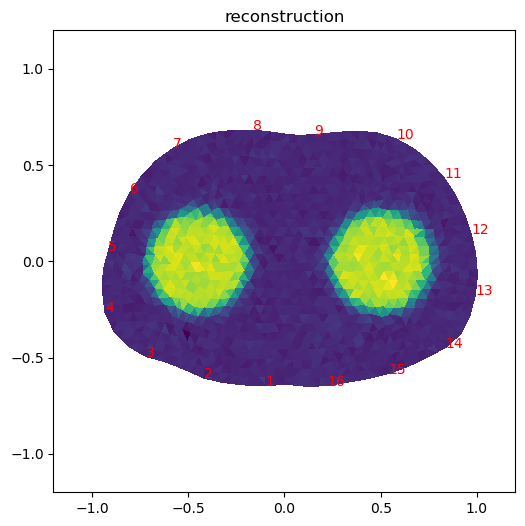

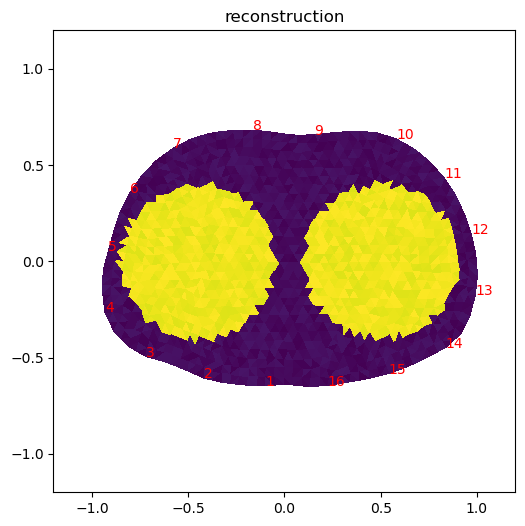

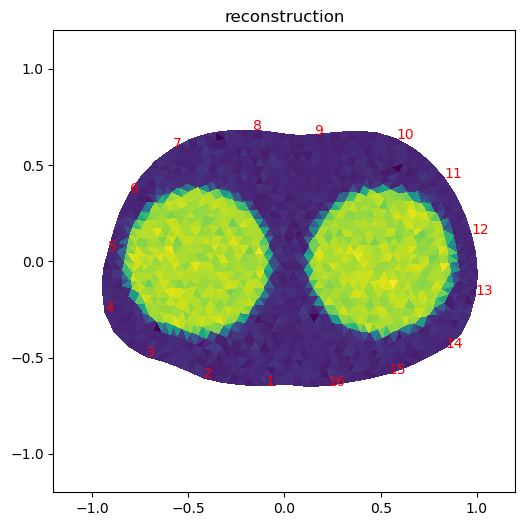

In [37]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_mapper_lstm[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_mapper_lstm[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_mapper_lstm[50, :])

<a id="comparison"></a>
# Comparison

- [1D Mapper](#1d_mapper)
- [2D Mapper](#2d_mapper)
- [LSTM Mapper](#lstmmapper)

In [38]:
try:
    plt.figure(figsize=(6, 4))
    plt.plot(history_mapper_lstm.history["loss"], c="C2", label="a) LSTM Mapper")
    plt.plot(history_mapper_2d.history["loss"], c="C1", label="b) 2D Mapper")
    plt.plot(history_mapper_1d.history["loss"], c="C3", label="c) 1D Mapper")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()
except BaseException:
    print("No training, no loss history.")

No training, no loss history.


<Figure size 600x400 with 0 Axes>

In [39]:
df = {
    "a) LSTM Mapper": err_mapper_lstm,
    "b) 2D Mapper": err_mapper_2d,
    "c) 1D Mapper": err_1d,
}
DF = pd.DataFrame.from_dict(df)

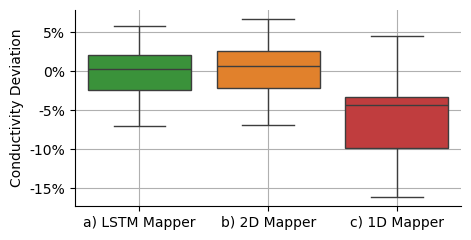

In [53]:
plt.figure(figsize=(4.75, 2.5))
# sns.set_theme(style="ticks", palette="muted")
sns.boxplot(
    data=DF,
    palette=["C2", "C1", "C3"],
    showfliers=True,
)  # set to false to hide outliers
sns.despine(offset=0, trim=False)
plt.ylabel("Conductivity Deviation")
plt.tight_layout()
tks = [tk for tk in range(-15, 5 + 1, 5)]
plt.yticks(ticks=tks, labels=[f"{n}%" for n in tks])
plt.grid()
#plt.savefig("../images/performance_estimation.pdf")

In [41]:
for key in df.keys():
    print(key, "mean:", np.mean(DF[key]))
    print(key, "std:", np.std(DF[key]))
    print(key, "var:", np.var(DF[key]))

a) LSTM Mapper mean: -0.179505660163886
a) LSTM Mapper std: 3.0215292811480525
a) LSTM Mapper var: 9.129639196835068
b) 2D Mapper mean: 0.23780440535279906
b) 2D Mapper std: 3.1027631348266076
b) 2D Mapper var: 9.627139070839037
c) 1D Mapper mean: -6.253627302879005
c) 1D Mapper std: 4.716173765043156
c) 1D Mapper var: 22.24229498208134


- [Back to mapper training](#trainmapper)
- [Back to Top](#start)

_Contact:_ `jacob.thoenes@uni-rostock.de`